In [105]:
import numpy as np
import pandas as pd
import pickle
from kdg.utils import trunk_sim, hellinger, plot_2dsim, sample_unifrom_circle
from kdg import kdn, kdf
from tensorflow import keras
from tensorflow.keras import activations
from joblib import Parallel, delayed
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

<AxesSubplot: >

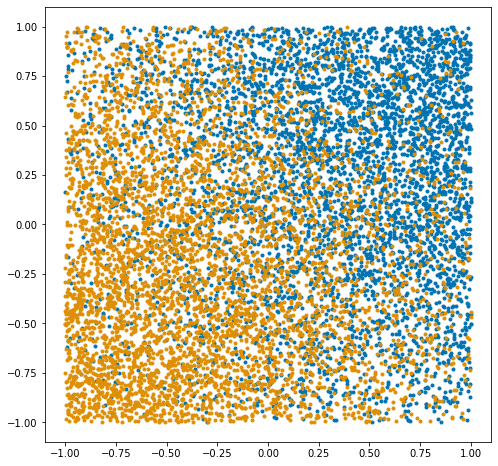

In [106]:
X, y = trunk_sim(10000, p_star=2, p=2)
plot_2dsim(X,y)

In [107]:
def get_trunk_posterior(x, p=2):
    mean = 1.0 / np.sqrt(np.arange(1, p + 1, 1))
    class1_likelihood = 0
    class2_likelihood = 0
    for ii in range(p):
        class1_likelihood += -(x[:,ii]-mean[ii])**2/(2) - .5*np.log(2*np.pi)
        class2_likelihood += -(x[:,ii]+mean[ii])**2/(2) - .5*np.log(2*np.pi)
    
    class1_likelihood = class1_likelihood.reshape(-1,1)
    class2_likelihood = class2_likelihood.reshape(-1,1)
    
    total_likelihood = np.concatenate((class1_likelihood,class2_likelihood),axis=1)
    max_likelihood = np.max(total_likelihood, axis=1).reshape(-1,1)
    class1_likelihood = np.exp(class1_likelihood-max_likelihood)
    class2_likelihood = np.exp(class2_likelihood-max_likelihood)
    
    posterior = np.hstack((class1_likelihood/(class1_likelihood+class2_likelihood),class1_likelihood/(class1_likelihood+class2_likelihood)))
                               
    return posterior

In [108]:
def getNN(input_size, num_classes, layer_size):
    network_base = keras.Sequential()
    initializer = keras.initializers.random_normal(seed=0)
    network_base.add(keras.layers.Dense(layer_size, kernel_initializer=initializer, input_shape=(input_size,)))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(layer_size, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(layer_size, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(layer_size, kernel_initializer=initializer))
    network_base.add(keras.layers.Activation(activations.relu))
    network_base.add(keras.layers.Dense(units=num_classes, activation="softmax", kernel_initializer=initializer))
    network_base.compile(**compile_kwargs)
    return network_base

In [109]:
compile_kwargs = {
        "loss": "binary_crossentropy",
        "optimizer": keras.optimizers.Adam(3e-4),
    }
callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10, verbose=True)
fit_kwargs = {
        "epochs": 200,
        "batch_size": 32,
        "verbose": False,
        "callbacks": [callback],
    }

In [ ]:
df = {}
model_kdf = kdf(kwargs={'n_estimators':500})
model_kdf.fit(X, y)
model_kdf.global_bias = -1e2

#define grids
p = np.arange(-2, 2, step=0.01)
q = np.arange(-2, 2, step=0.01)
xx, yy = np.meshgrid(p, q)

grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
posterior_rf = model_kdf.rf_model.predict_proba(grid_samples)
posterior_kdf, likelihoods_kdf = model_kdf.predict_proba(grid_samples, return_likelihood=True)
posterior_kdf_geod, likelihoods_kdf_geod = model_kdf.predict_proba(grid_samples, distance='Geodesic', return_likelihood=True)


posterior_rf = posterior_rf[:,0].reshape(400,400)
posterior_kdf = posterior_kdf[:,0].reshape(400,400)
class1_likelihoods_kdf = likelihoods_kdf[:,0].reshape(400,400)
class2_likelihoods_kdf = likelihoods_kdf[:,1].reshape(400,400)

posterior_kdf_geod = posterior_kdf_geod[:,0].reshape(400,400)
class1_likelihoods_geod_kdf = likelihoods_kdf_geod[:,0].reshape(400,400)
class2_likelihoods_geod_kdf = likelihoods_kdf_geod[:,1].reshape(400,400)

df['posterior_rf'] = posterior_rf
df['posterior_kdf'] = posterior_kdf
df['likelihood_class1_kdf'] = class1_likelihoods_kdf
df['likelihood_class2_kdf'] = class2_likelihoods_kdf
df['posterior_kdf_geod'] = posterior_kdf_geod
df['likelihood_class1_geod_kdf'] = class1_likelihoods_geod_kdf
df['likelihood_class2_geod_kdf'] = class2_likelihoods_geod_kdf

In [ ]:
nn = getNN(
            input_size=X.shape[1],
            num_classes=2, 
            layer_size=100
        )
history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
model_kdn = kdn(network=nn)
model_kdn.fit(X, y)

model_kdn.gloabel_bias = -1e2
posterior_dn = model_kdn.network.predict(grid_samples)
posterior_kdn, likelihoods_kdn = model_kdn.predict_proba(grid_samples, return_likelihood=True)
posterior_kdn_geod, likelihoods_kdn_geod = model_kdn.predict_proba(grid_samples, distance='Geodesic', return_likelihood=True)

posterior_dn = posterior_dn[:,0].reshape(400,400)
posterior_kdn = posterior_kdn[:,0].reshape(400,400)
class1_likelihoods_kdn = likelihoods_kdn[:,0].reshape(400,400)
class2_likelihoods_kdn = likelihoods_kdn[:,1].reshape(400,400)

posterior_kdn_geod = posterior_kdn_geod[:,0].reshape(400,400)
class1_likelihoods_geod_kdn = likelihoods_kdn_geod[:,0].reshape(400,400)
class2_likelihoods_geod_kdn = likelihoods_kdn_geod[:,1].reshape(400,400)


df['posterior_dn'] = posterior_dn
df['posterior_kdn'] = posterior_kdn
df['likelihood_class1_kdn'] = class1_likelihoods_kdn
df['likelihood_class2_kdn'] = class2_likelihoods_kdn
df['posterior_kdn_geod'] = posterior_kdn_geod
df['likelihood_class1_geod_kdn'] = class1_likelihoods_geod_kdn
df['likelihood_class2_geod_kdn'] = class2_likelihoods_geod_kdn

In [ ]:
p = np.arange(-1, 1, step=0.01)
q = np.arange(-1, 1, step=0.01)
xx, yy = np.meshgrid(p, q)

grid_samples = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
proba_true = 0.5*np.ones((400, 400))
tmp = get_trunk_posterior(grid_samples)[:,0]

proba_true[100:300, 100:300] = 1 - tmp.reshape(200, 200)

In [ ]:
fig1, ax = plt.subplots(1, 7, figsize=(30, 210))

p = np.arange(-2, 2, step=0.01)
q = np.arange(-2, 2, step=0.01)
xx, yy = np.meshgrid(p, q)

ax0 = ax[0].imshow(
    np.fliplr(proba_true),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[0].set_title("True Posteriors", fontsize=24)
ax[0].set_aspect("equal")

ax1 = ax[1].imshow(
    np.fliplr(posterior_rf),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[1].set_title("RF Posteriors", fontsize=24)
ax[1].set_aspect("equal")

ax2 = ax[2].imshow(
    np.fliplr(posterior_kdf),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[2].set_title("KDF-Euclidean\n Posteriors", fontsize=24)
ax[2].set_aspect("equal")

ax2 = ax[3].imshow(
    np.fliplr(posterior_kdf_geod),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[3].set_title("KDF-Geodesic\n Posteriors", fontsize=24)
ax[3].set_aspect("equal")

ax1 = ax[4].imshow(
    np.fliplr(posterior_dn),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[4].set_title("DN Posteriors", fontsize=24)
ax[4].set_aspect("equal")

ax2 = ax[5].imshow(
    np.fliplr(posterior_kdn),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[5].set_title("KDN-Euclidean\n Posteriors", fontsize=24)
ax[5].set_aspect("equal")

ax2 = ax[6].imshow(
    np.fliplr(posterior_kdn_geod),
    extent=[xx.min(), xx.max(), yy.min(), yy.max()],
    cmap="bwr",
    vmin=0,
    vmax=1,
    interpolation="nearest",
    aspect="auto",
)
ax[6].set_title("KDN-Geodesic\n Posteriors", fontsize=24)
ax[6].set_aspect("equal")
plt.show()

In [ ]:
# %%
##### main hyperparameters #####
mc_reps = 10
signal_dimension = [1, 10, 100, 200, 400, 600, 800, 1000]
train_sample = 5000
test_sample = 1000

In [ ]:
def experiment(dim):
    X, y = trunk_sim(train_sample, p_star=dim, p=dim)
    X_test, y_test = trunk_sim(test_sample, p_star=dim, p=dim)
    true_posterior = get_trunk_posterior(X_test,p=dim)

    model_kdf = kdf(kwargs={'n_estimators':500})
    model_kdf.fit(X, y)

    nn = getNN(
            input_size=X.shape[1],
            num_classes=2, 
            layer_size=100
        )
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    model_kdn = kdn(network=nn)
    model_kdn.fit(X, y)
    
    proba_kdf = model_kdf.predict_proba(X_test)
    proba_kdf_geodesic = model_kdf.predict_proba(X_test, distance='Geodesic')
    proba_kdn = model_kdn.predict_proba(X_test)
    proba_kdn_geodesic = model_kdn.predict_proba(X_test, distance='Geodesic')
    proba_rf = model_kdf.rf_model.predict_proba(X_test)
    proba_dn = model_kdn.network.predict(X_test)
    
    kdf_err = 1 - \
        np.mean(np.argmax(proba_kdf,axis=1)==y_test)
    kdf_err_geodesic = 1 - \
        np.mean(np.argmax(proba_kdf_geodesic,axis=1)==y_test)
    
    kdf_hellinger = hellinger(
                        true_posterior,
                        proba_kdf
                    )
    kdf_geodesic_hellinger = hellinger(
                        true_posterior,
                        proba_kdf_geodesic
                    )
    
    
    kdn_err = 1 - \
        np.mean(np.argmax(proba_kdn,axis=1)==y_test)
    kdn_err_geodesic = 1 - \
        np.mean(np.argmax(proba_kdn_geodesic,axis=1)==y_test)
    
    kdn_hellinger = hellinger(
                        true_posterior,
                        proba_kdn
                    )
    kdn_geodesic_hellinger = hellinger(
                        true_posterior,
                        proba_kdn_geodesic
                    )
    
    rf_err = 1 - \
        np.mean(np.argmax(proba_rf,axis=1)==y_test)
    dn_err = 1 - \
        np.mean(np.argmax(proba_dn,axis=1)==y_test)
    
    rf_hellinger = hellinger(
                        true_posterior,
                        proba_rf
                    )
    dn_geodesic_hellinger = hellinger(
                        true_posterior,
                        proba_dn
                    )
    
    #print(kdn_err, kdn_err_geodesic, kdf_err, kdf_err_geodesic, rf_err, dn_err, kdn_hellinger, kdn_geodesic_hellinger, kdf_hellinger, kdf_geodesic_hellinger, rf_hellinger, dn_geodesic_hellinger)
    return kdn_err, kdn_err_geodesic, kdf_err, kdf_err_geodesic, rf_err, dn_err, kdn_hellinger, kdn_geodesic_hellinger, kdf_hellinger, kdf_geodesic_hellinger, rf_hellinger, dn_geodesic_hellinger


In [ ]:
err_kdn = []
err_kdf = []
err_dn = []
err_rf = []
err_kdf_geodesic = []
err_kdn_geodesic = []
hel_kdn = []
hel_kdf = []
hel_dn = []
hel_rf = []
hel_kdf_geodesic = []
hel_kdn_geodesic = []
dimension = []

for dim in signal_dimension:
    print('doing dim ', dim)
    res = []
    for _ in range(mc_reps):
        res.append(experiment(dim))
    
    for ii in range(mc_reps):
        err_kdn.append(
            res[ii][0]
        )
        err_kdn_geodesic.append(
            res[ii][1]
        )
        err_kdf.append(
            res[ii][2]
        )
        err_kdf_geodesic.append(
            res[ii][3]
        )
        err_rf.append(
            res[ii][4]
        )
        err_dn.append(
            res[ii][5]
        )
        
        hel_kdn.append(
            res[ii][6]
        )
        hel_kdn_geodesic.append(
            res[ii][7]
        )
        hel_kdf.append(
            res[ii][8]
        )
        hel_kdf_geodesic.append(
            res[ii][9]
        )
        hel_rf.append(
            res[ii][10]
        )
        hel_dn.append(
            res[ii][11]
        )
        dimension.append(
            dim
        )

df['err_kdn'] = err_kdn
df['err_kdf'] = err_kdf
df['err_dn'] = err_dn
df['err_rf'] = err_rf
df['err_kdf_geodesic'] = err_kdf_geodesic
df['err_kdn_geodesic'] = err_kdn_geodesic

df['kdn_hellinger'] = hel_kdn
df['kdf_hellinger'] = hel_kdf
df['dn_hellinger'] = hel_dn
df['rf_hellinger'] = hel_rf
df['kdf_geodesic_hellinger'] = hel_kdf_geodesic
df['kdn_geodesic_hellinger'] = hel_kdn_geodesic

df['dimension'] = dimension


In [ ]:
def experiment_out(dim, n_test=1000, r=20):
    X, y = trunk_sim(train_sample, p_star=dim, p=dim)
    X /= np.max(
        np.linalg.norm(X, 2, axis=1)
    )
    X_ood = sample_unifrom_circle(n=n_test, r=r, p=dim)
    true_posterior = get_trunk_posterior(X_ood,p=dim)
    
    model_kdf = kdf(kwargs={'n_estimators':500})
    model_kdf.fit(X, y)
    model_kdf.global_bias = -1e3

    nn = getNN(
            input_size=X.shape[1],
            num_classes=2, 
            layer_size=100
        )
    history = nn.fit(X, keras.utils.to_categorical(y), **fit_kwargs)
    model_kdn = kdn(network=nn)
    model_kdn.fit(X, y)
    model_kdn.global_bias = -1e3
    
    conf_kdf = np.nanmean(
                    np.max(model_kdf.predict_proba(X_ood), axis=1)
                )
    conf_kdf_geodesic = np.nanmean(
                    np.max(model_kdf.predict_proba(X_ood, distance='Geodesic'), axis=1)
                )
    conf_kdn = np.nanmean(
                    np.max(model_kdn.predict_proba(X_ood), axis=1)
                )
    conf_kdn_geodesic = np.nanmean(
                    np.max(model_kdn.predict_proba(X_ood, distance='Geodesic'), axis=1)
                )
    conf_rf = np.nanmean(
                    np.max(model_kdf.rf_model.predict_proba(X_ood), axis=1)
                )
    conf_dn = np.nanmean(
                    np.max(model_kdn.network.predict(X_ood), axis=1)
                )
    
    
    
    return conf_kdn, conf_kdn_geodesic, conf_kdf, conf_kdf_geodesic, conf_rf, conf_dn

In [ ]:
conf_kdn = []
conf_kdf = []
conf_dn = []
conf_rf = []
conf_kdf_geodesic = []
conf_kdn_geodesic = []
dimension = []

for dim in signal_dimension:
    print('doing dim ', dim)
    res = []
    for _ in range(mc_reps):
        res.append(experiment_out(dim))
    
    for ii in range(mc_reps):
        conf_kdn.append(
            res[ii][0]
        )
        conf_kdn_geodesic.append(
            res[ii][1]
        )
        conf_kdf.append(
            res[ii][2]
        )
        conf_kdf_geodesic.append(
            res[ii][3]
        )
        conf_rf.append(
            res[ii][4]
        )
        conf_dn.append(
            res[ii][5]
        )
        
        dimension.append(
            dim
        )

df['conf_kdn_ood'] = conf_kdn
df['conf_kdf_ood'] = conf_kdf
df['conf_dn_ood'] = conf_dn
df['conf_rf_ood'] = conf_rf
df['conf_kdf_geodesic_ood'] = conf_kdf_geodesic
df['conf_kdn_geodesic_ood'] = conf_kdn_geodesic

In [ ]:
name = 'trunk2'
filename = name + ".pickle"

with open(filename, 'wb') as f:
    pickle.dump(df, f)

In [18]:
dim

10

In [19]:
experiment(dim)

ValueError: Found input variables with inconsistent numbers of samples: [3887, 5000]

In [96]:
X, y = trunk_sim(500, p_star=40, p=40)

In [97]:
X.shape

(500, 40)

In [98]:
y.shape

(500,)

In [23]:
train_sample

5000

In [94]:
from scipy.stats import truncnorm

def trunk_sim(n_samples, p_star=3, p=3, center_box=(-1.0, 1.0), random_state=None):
    samples_per_class = np.random.multinomial(n_samples, 1 / 2 * np.ones(2))

    mean = 1.0 / np.sqrt(np.arange(1, p_star + 1, 1))
    
    X_1 = truncnorm.rvs(
        (center_box[0]-mean[0]),
        (center_box[1]-mean[0]),
        mean[0],
        1,
        size=samples_per_class[0]
    ).reshape(-1,1)
    
    for ii in range(1,p_star):
        X_1 = np.concatenate(
            (X_1,
            truncnorm.rvs(
                    (center_box[0]-mean[ii]),
                    (center_box[1]-mean[ii]),
                    mean[ii],
                    1,
                    size=samples_per_class[0]
                ).reshape(-1,1)
            ),
            axis=1
        )
    
    
    X_2 = truncnorm.rvs(
        (center_box[0]+mean[0]),
        (center_box[1]+mean[0]),
        -mean[0],
        1,
        size=samples_per_class[1]
    ).reshape(-1,1)
    
    for ii in range(1,p_star):
        X_2 = np.concatenate(
            (X_2,
            truncnorm.rvs(
                    (center_box[0]+mean[ii]),
                    (center_box[1]+mean[ii]),
                    -mean[ii],
                    1,
                    size=samples_per_class[1]
                ).reshape(-1,1)
            ),
            axis=1
        )
        

    X = np.concatenate(
        (X_1,X_2),
        axis=0,
    )
    y = np.concatenate(
        (np.zeros(samples_per_class[0]), np.ones(samples_per_class[1])), axis=0
    )


    if p > p_star:
        X_noise = np.random.uniform(
            low=center_box[0], high=center_box[1], size=(n_samples, p - p_star)
        )
        X = np.concatenate((X, X_noise), axis=1)

    return X, y.astype(int)


In [86]:
X, y = trunk_sim(5000, p_star=10, p=10)

In [87]:
X.shape

(5000, 10)

In [89]:
X

array([[ 0.4894696 ,  0.12677384, -0.31389475, ...,  1.07065488,
         0.2083829 ,  0.81370495],
       [ 0.26479905,  0.71535697,  0.52626951, ...,  1.34207686,
         1.29813872,  0.95622277],
       [ 0.46895354,  0.52689434,  1.18718735, ...,  0.01206531,
         0.82516141,  0.60691784],
       ...,
       [-0.13834998, -1.14836396, -0.07968579, ..., -0.19540108,
        -0.83988646, -1.43547935],
       [-0.71946199, -0.9304969 , -1.09414857, ..., -0.08894233,
        -1.25671084,  0.1982186 ],
       [-0.74603336, -1.23656076, -0.6789338 , ..., -0.413622  ,
        -0.71474913, -0.18621544]])

(array([ 2.,  3.,  7.,  6., 13.,  3., 17., 16., 17., 16.]),
 array([-0.94423087, -0.75428214, -0.56433341, -0.37438468, -0.18443596,
         0.00551277,  0.1954615 ,  0.38541023,  0.57535896,  0.76530769,
         0.95525642]),
 <BarContainer object of 10 artists>)

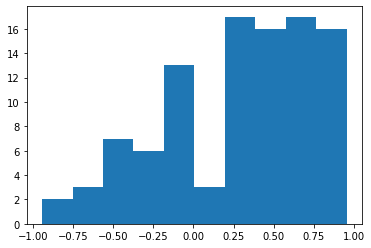

In [74]:
plt.hist(X_1)

In [72]:
X_1.shape

()